# [ CNN ] OOD Detection using FSS

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_CNN
from core.data_loader import TRAIN_loader, TEST_loader
from core.fisher_utils_CNN import Calculate_fisher_CNN, Calculate_score_CNN, AUTO_CNN
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# Define Global Variables & Initialize

In [3]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'cifar10': {}, 'fmnist': {}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'cifar10': {}, 'fmnist': {}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'cifar10': {}, 'fmnist': {}}


# CNN

In [24]:
opt = config.CNN_cifar10
model = load_pretrained_CNN(option=opt.train_dist, augment='None', epoch=150)
model.eval()

acc = 0
loader = TEST_loader(opt.train_dist, opt.train_dist, shuffle=True)
for i, (x,y) in enumerate(loader):
    pred = model(x.float().cuda())
    if torch.argmax(pred).detach().cpu() == y:
        acc += 1
    print(f'{acc/(i+1):.4f}', end='\r')
    if i==1000:
        break
torch.cuda.empty_cache()

Files already downloaded and verified


In [13]:
layers = {
    'C1': model.conv1,
    'L1B0C1': model.layer1[0].conv1,
    'L1B0C2': model.layer1[0].conv2,
    'L1B1C1': model.layer1[1].conv1,
    'L1B1C2': model.layer1[1].conv2,
    'L2B0C1': model.layer2[0].conv1,
    'L2B0C2': model.layer2[0].conv2,
    'L2B1C1': model.layer2[1].conv1,
    'L2B1C2': model.layer2[1].conv2,
    'L3B0C1': model.layer3[0].conv1,
    'L3B0C2': model.layer3[0].conv2,
    'L3B1C1': model.layer3[1].conv1,
    'L3B1C2': model.layer3[1].conv2,
    'L4B0C1': model.layer4[0].conv1,
    'L4B0C2': model.layer4[0].conv2,
    'L4B1C1': model.layer4[1].conv1,
    'L4B1C2': model.layer4[1].conv2,
    'fc': model.linear,
}

In [14]:
a, b, _scores = AUTO_CNN(opt, model, layers, max_iter=[1000, 1000], method='Vanilla')

Files already downloaded and verified


Calculate Fisher CNN:   2%|█                                                     | 999/50000 [00:14<11:27, 71.32step/s]


Files already downloaded and verified


Calculate Fisher CNN:  10%|█████▍                                                | 999/10000 [00:14<02:08, 69.84step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Fisher CNN:  33%|██████████████████▎                                    | 999/3000 [00:15<00:30, 65.77step/s]


Files already downloaded and verified


Calculate Fisher CNN:  10%|█████▍                                                | 999/10000 [00:13<02:02, 73.39step/s]


Files already downloaded and verified


Calculate Fisher CNN:  10%|█████▍                                                | 999/10000 [00:12<01:51, 80.62step/s]


In [15]:
for lname in layers.keys():
    FISHERs[opt.train_dist][lname] = a[lname] 
    NORM_FACs[opt.train_dist][lname] = b[lname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for lname in layers.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][lname],
            SCOREs[opt.train_dist][ood][lname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[lname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

,svhn,celeba,lsun,cifar100,mnist,fmnist,kmnist,omniglot,notmnist,noise,constant
C1,0.500841,0.422678,0.508515,0.493691,0.142671,0.282578,0.123211,0.647762,0.183895,0.251872,0.145418
L1B0C1,0.633555,0.581933,0.501010,0.541704,0.593069,0.391176,0.484350,0.330766,0.360509,0.184733,0.605617
L1B0C2,0.357318,0.581735,0.542883,0.552930,0.524717,0.342416,0.473534,0.359020,0.309453,0.640851,0.685896
L1B1C1,0.440470,0.595228,0.493707,0.523864,0.542879,0.329948,0.420298,0.323648,0.208467,0.299487,0.306315
L1B1C2,0.486734,0.479612,0.565465,0.513034,0.207875,0.315705,0.205725,0.272511,0.125702,0.732105,0.085785
L2B0C1,0.381507,0.634455,0.535896,0.526691,0.498549,0.325815,0.356286,0.207832,0.148041,0.760592,0.056133
L2B0C2,0.419229,0.643382,0.553387,0.530274,0.486884,0.339240,0.427770,0.418441,0.181455,0.973647,0.033026
L2B1C1,0.490778,0.698406,0.556551,0.544199,0.648956,0.466417,0.624283,0.645855,0.365627,0.486082,0.091097
L2B1C2,0.420676,0.694364,0.554573,0.555448,0.832527,0.660712,0.774596,0.879804,0.742312,0.152973,0.656888
L3B0C1,0.155696,0.680485,0.540015,0.507398,0.536650,0.345478,0.505329,0.498834,0.183988,0.915066,0.027238


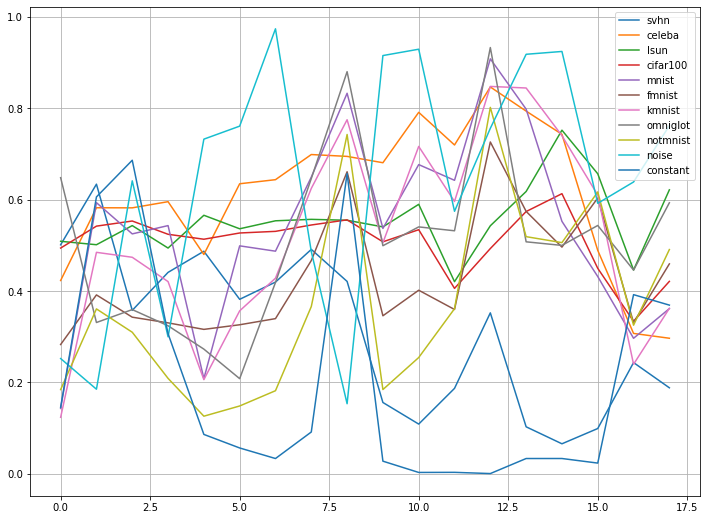

In [16]:
x = range(len(df.index))
fig = plt.figure(figsize=(12, 9))
for ood in df.columns:
    plt.plot(x, df.loc[:, ood], label=ood)
plt.grid()
plt.legend()
plt.show()
fig.savefig('./temp.png')

# CNN-FMNIST

In [3]:
opt = config.CNN_fmnist
model = load_pretrained_CNN(option=opt.train_dist)
model.eval()

layers = {
    'conv1': model.layer1[0],
    'conv2': model.layer2[0],
    'conv3': model.layer3[0],
    'fc1': model.fc1,
    'conv4': model.layer4[0],
    'fc2': model.fc2,
}

In [5]:
a, b, _scores = AUTO_CNN(opt, model, layers, max_iter=[10000, 5000], method='Vanilla')

Calculate Fisher CNN:  50%|█████████████████████████▉                          | 4999/10000 [00:16<00:16, 308.22step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Fisher CNN: 100%|█████████████████████████████████████████████████████| 3000/3000 [00:16<00:00, 176.47step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|█████████████████████████▉                          | 4999/10000 [00:17<00:17, 290.06step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|█████████████████████████▉                          | 4999/10000 [00:16<00:16, 306.72step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|█████████████████████████▉                          | 4999/10000 [00:14<00:14, 336.08step/s]


In [6]:
for lname in layers.keys():
    FISHERs[opt.train_dist][lname] = a[lname] 
    NORM_FACs[opt.train_dist][lname] = b[lname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for lname in layers.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][lname],
            SCOREs[opt.train_dist][ood][lname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[lname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

,svhn,celeba,lsun,cifar10,cifar100,mnist,kmnist,omniglot,notmnist,noise,constant
conv1,0.775341,0.744390,0.791949,0.774469,0.767601,0.587081,0.588806,0.796495,0.624263,0.619036,0.595314
conv2,0.628985,0.725461,0.753962,0.737778,0.732672,0.837455,0.862066,0.761549,0.734627,0.983552,0.541435
conv3,0.681535,0.844235,0.815000,0.797763,0.789628,0.933008,0.951465,0.874326,0.860421,0.969250,0.585096
fc1,0.934412,0.973320,0.965795,0.964545,0.961665,0.984879,0.990875,0.983450,0.980693,0.993000,0.890928
conv4,0.934412,0.973320,0.965795,0.964545,0.961665,0.984879,0.990875,0.983450,0.980693,0.993000,0.890928
fc2,0.983740,0.953875,0.974473,0.975952,0.974419,0.989653,0.974496,0.995277,0.981090,0.975603,0.954153


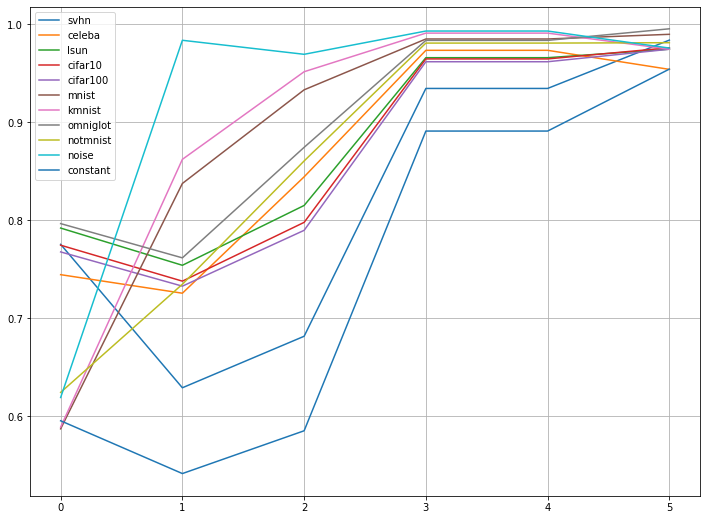

In [10]:
x = range(len(df.index))
fig = plt.figure(figsize=(12, 9))
for ood in df.columns:
    plt.plot(x, df.loc[:, ood], label=ood)
plt.grid()
plt.legend()
plt.show()
fig.savefig('./temp.png')

In [6]:
# Just show scores
# plot_scores_all_layers(train_dist, params, SCOREs, opt, save=True)
